In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from rlhfutils.rl_utils import get_synth_rewards
from tqdm import tqdm
import numpy as np

from datasets import Dataset, concatenate_datasets
import seaborn as sns

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-03-24 13:29:27,069] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/trl/trainer/ppo_config.py:142: UserWarning: The `optimize_cuda_cache` argument will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def loadf(fname): 
    tlog = pd.read_json(fname, orient='records', lines=True)
    tmp = tlog
    if 'golds' not in tmp.keys():
        tmp['golds'] = tmp['rewards']
    tmp = tmp.dropna(subset='golds')
    print(len(tmp))
    return tmp

# Function to create a scatter plot comparing a baseline method to a new method
def ratio_scatter(baseline, method, steps=2000, baseratio=1, methodratio=1, fname="output.pdf", setname="Experiment Results", methmax=True, labels=['OPO with Gold', "ARMoUR"]):
    # Set the aesthetic style of the plots to be more appealing and professional
    sns.set(style="whitegrid")

    # Normalize the x-axis values for each list
    baseline_x = np.linspace(0, steps, len(baseline)) * baseratio
    method_x = np.linspace(0, steps, len(method)) * methodratio

    if methmax:
        # Determine the max x-axis value based on the smaller dataset
        max_x_value = min(max(baseline_x), max(method_x))
        
        # Filter out the points that exceed the max_x_value for both datasets
        baseline_x, baseline = zip(*[(x, y) for x, y in zip(baseline_x, baseline) if x <= max_x_value])
        method_x, method = zip(*[(x, y) for x, y in zip(method_x, method) if x <= max_x_value])

    # Creating a figure and axis object
    plt.figure(figsize=(10, 6))

    # Plot each dataset using seaborn for better aesthetics
    if baseratio>=0:
        sns.scatterplot(x=baseline_x, y=baseline, color='blue', label=labels[0], s=75)
    sns.scatterplot(x=method_x, y=method, color='red', label=labels[1], s=25, edgecolor='red')

    # Adding enhancements for clarity and aesthetics
    plt.title(setname, fontsize=26, fontweight='bold')
    plt.xlabel('Gold Preference Data Used', fontsize=20)
    plt.ylabel('Average Gold Reward' if baseratio>=0 else "RM Accuracy on Samples", fontsize=20)
    plt.legend(prop={'size': 16})
    plt.tight_layout()

    # Saving the figure in high-quality
    plt.savefig(fname, format="pdf", bbox_inches="tight")

    plt.show()

def makengs(tmpdf, sind=0): 
    rat = 0
    ngs = []
    accs = []
    sind = 0
    for ind, row in tmpdf.iloc[sind:].iterrows():
        # row['golds'] = get_synth_rewards(row['texts'], 'bagofwords')
        if len(row['golds'])==0:
            continue
        ngs.append(row['golds'])
        if row['golds'][0]==row['golds'][1]:
                continue
        if ((row['rewards'][0]>row['rewards'][1])!=(row['golds'][0]>row['golds'][1])):
            rat+=1
            accs.append(0)
        else:
            accs.append(1)
    #tmp['golds'] = ngs
    print(rat/len(ngs))
    return ngs, accs

def accscatter(acclist, interv=200): 
    vals = []
    for j in range(0, len(acclist), interv):
        vals.append(mean(acclist[j:j+interv]))
    return plt.scatter(range(len(vals)), vals)
    

In [47]:
# baselines for all our things
basefs = {
    'nouns':"../outputs/results/rollouts/nouns/ppo_goldb8.jsonl",
    'bagofwords':"../outputs/results/rollouts/bagofwords/ppo_goldb8_dpobase_v2.jsonl",
    'math':"../outputs/results/rollouts/math/ppo_goldb8easy4fix.jsonl",
    'cdist':"../outputs/results/rollouts/contrastivedistill/ppo_goldb8.jsonl",
    'ultra':"../outputs/results/rollouts/ultra/ppo_ultragolddpoplusfinal2.jsonl"
}

# using only fixed distribution data, in ARMOUR fashion
basefs = {
    'nouns':"../outputs/results/dynarmlogs//nouns/smalldpo_confnoun_newalgo_2_5_seed2_dpoapi.jsonl",
    'bagofwords':"../outputs/results/dynarmlogs/bagofwords/bowtiny_dpo_conf_newalgo_5testnewseed2_dpoapi.jsonl",
    'cdist':"../outputs/results/dynarmlogs/contrastivedistill/smalldpo_rand_cdist_10_5_activefixseed2.jsonl",
}


# using only fixed distribution data, in ARMOUR fashion
basefs = {
    'nouns':"../outputs/results/dynarmlogs//nouns/tiny_rm_confnoun_newalgo_2_5_seed2_oldupdates.jsonl",
    'bagofwords':"../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed2_oldupdates.jsonl",
    'cdist':"../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed2_oldupdates.jsonl",
}

# using only fixed distribution data, in ARMOUR fashion
basefs = {
    'nouns':"../outputs/results/rollouts/nouns/ppo_confnoun_goldb8_4ups.jsonl",
    'bagofwords':"../outputs/results/rollouts//bagofwords/ppo_conf_newalgo_goldb8_1ups.jsonl",
    'cdist':"../outputs/results/rollouts/contrastivedistill/ppo_contdistb8_moreupdates_4ups.jsonl",
}

# more spaced out
basefs = {
    'nouns':"../outputs/results/dynarmlogs//nouns/tiny_rm_randnoun_newalgo_100small_200testv3.jsonl",
    'bagofwords':"../outputs/results/dynarmlogs//bagofwords/bowtiny_rm_conf_newalgo_100small_500test.jsonl",
    'cdist':"../outputs/results/dynarmlogs/contrastivedistill/smalldpo_rand_cdist_10_5_activefixseed2.jsonl",
}

# basefs = {
#     'nouns':"../outputs/results/rollouts/nouns/ppo_confnoun_goldb8_selfreward.jsonl",
#     'bagofwords':"../outputs/results/rollouts/bagofwords/ppo_confbow_goldb8_selfreward.jsonl",
#     'cdist':"../outputs/results/rollouts/contrastivedistill/ppo_confcdist_goldb8_selfreward.jsonl",
# }

# methods that do the best in each thing
bestmethds = {
    'nouns':["../outputs/results/dynarmlogs/nouns/tiny_rm_confnoun_newalgo_2small_5testv3new.jsonl",
             "../outputs/results/dynarmlogs/nouns/tiny_rm_confnoun_newalgo_2_5_seed2.jsonl",
             "../outputs/results/dynarmlogs/nouns/tiny_rm_confnoun_newalgo_2_5_seed3.jsonl",
            ],
    'bagofwords':["../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnew.jsonl",
                  "../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed2.jsonl",
                  "../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed3.jsonl",
                 ],
    'math':"../outputs/results/dynarmlogs/math/tiny_rm_rand8repeasy4_1v2fix.jsonl",
    'cdist':["../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed3.jsonl",
             "../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed2.jsonl",
             "../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefix.jsonl"
            ],
    'ultra':"../outputs/results/dynarmlogs/ultra/tiny_rm_conf_active_newalgoultra.jsonl"
}
# seeds
# bestmethds = {
#     'nouns':"../outputs/results/dynarmlogs/nouns/tiny_rm_confnoun_newalgo_2_5_seed3.jsonl",
#     'bagofwords':"../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed3.jsonl",
#     'math':"../outputs/results/dynarmlogs/math/tiny_rm_easy4_32_2_try_seed2.jsonl",
#     'cdist':"../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed3.jsonl",
#     'ultra':"../outputs/results/dynarmlogs/ultra/tiny_rm_conf_active_newalgoultra.jsonl"
# }

mratios = {'bagofwords':2, 'nouns':0.4, 'math':2, 'cdist':1, 'ultra':8}
dset = "nouns"
tmpbase = loadf(basefs[dset])
basengs, baseaccs = makengs(tmpbase)
print("loaded base")
allmethngs = []
allmethaccs = []
# have a  list of stuff, TODO there's a better way to check this
if len(bestmethds[dset])<5:
    for d in bestmethds[dset]:
        tmpmethod = loadf(d)
        methngs, methaccs = makengs(tmpmethod)
        allmethngs.append(methngs)
        allmethaccs.append(methaccs)
        
print("loaded method")

# tlog = pd.read_json("../../active-rlhf/outputs/results/rollouts/math/ppo_goldb8easy4fix.jsonl", orient='records', lines=True, nrows=64000)
# tlog = pd.read_json("../../outputs/bagofwords/dynarmlogs/expbow50_updatereprod_fix.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../../activereprod/active-rlhf/outputs/results/dynarmlogs/math/u/prasanns/research/active-rlhf/outputs/models/math/tiny_rm_rand_subsamp_onlymathreprod3.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../outputs/results/dynarmlogs/.jsonl", orient='records', lines=True)

64000
0.054828125
loaded base
64000
0.07109375
64080
0.08186641697877653
64000
0.078984375
loaded method


In [48]:
baseratio = 8

In [49]:
# get sliding window means over some input list (smoothened)
def intervmean(vals, interv=50, window=400):
    return [mean(vals[i:i+window]) for i in range(0, len(vals)-window, interv)]    

def combineall(vallists, inte=50, wind=400):
    newls = [[mean(m) for m in blist] for blist in vallists]
    finl = []
    for i in range(len(newls[0])):
        finl.append(mean([newls[j][i] for j in range(len(newls))]))
    return finl

basemeans = intervmean([mean(m) for m in basengs], 5, 25)
methmeans = intervmean(combineall(allmethngs), 25 , 50)
baseacms = intervmean(baseaccs, 25, 500)
methacms = intervmean(methaccs, 25 , 500)

In [50]:
mean(methmeans[-20:-10])

48.537333333333336

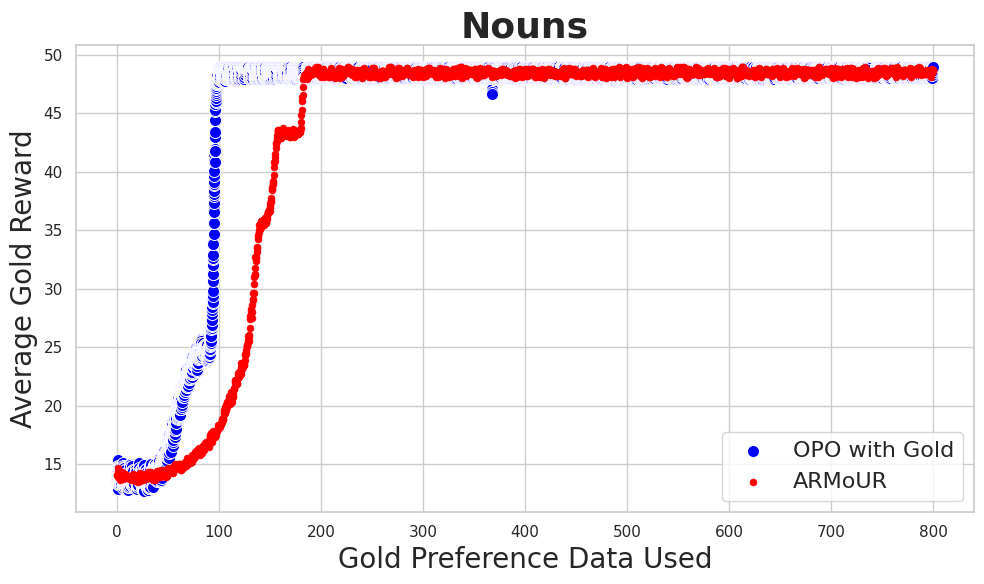

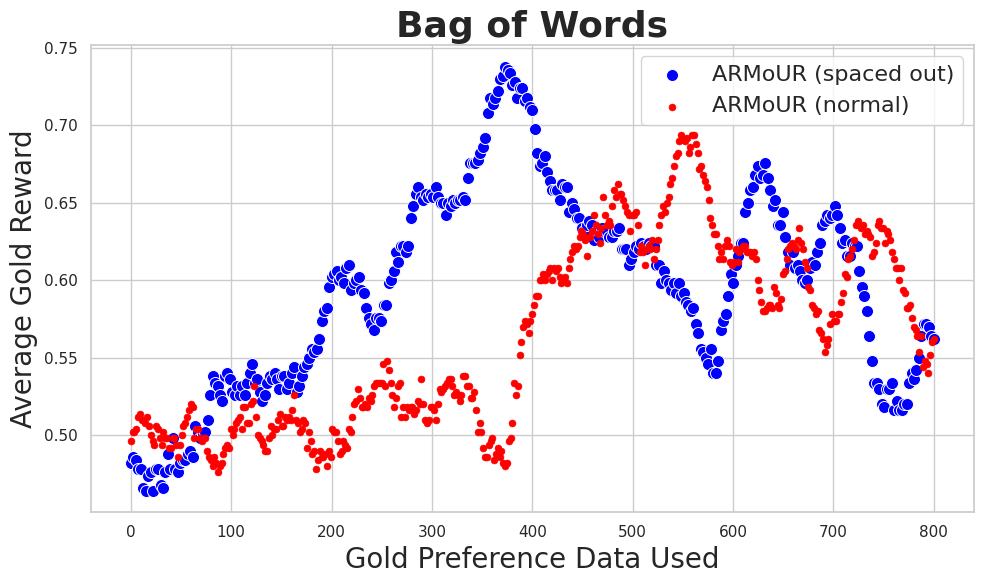

In [52]:
fig = ratio_scatter(basemeans, methmeans, 2000, mratios[dset], mratios[dset], "efficientplots/"+dset+".pdf", "Nouns")
# fig = ratio_scatter(basemeans, basemeans, 2000, baseratio, baseratio, "efficientplots/tmp"+".pdf", "tmp")

fig = ratio_scatter(baseacms, methacms, 2000, mratios[dset], mratios[dset], "efficientplots/acc"+dset+".pdf", "Bag of Words", methmax=False, labels=['ARMoUR (spaced out)', 'ARMoUR (normal)'])

In [30]:
def splitter(inp):
    # qa style
    if ("Question:" in inp) and "Answer:" in inp: 
        instruction, response = inp.split("\n\nAnswer: ")
        instruction = instruction[len("Question: "):]
    # alpacafarm style
    if "### Instruction:" in inp:
        instruction_match = re.search(r'### Instruction:\n(.*?)(### Response:|\Z)', inp, re.DOTALL)
        instruction = instruction_match.group(1).strip() if instruction_match else inp
        # Extract Response
        response_match = re.search(r'### Response:.*?(.*?)(### |\Z)', inp, re.DOTALL)
        response = response_match.group(1).strip() if response_match else ""
    # tulu style
    if "<user>" in inp: 
        q = inp[len("<user>\n"):]
        instruction, response = q.split("\n<assistant>\n")
    
    return instruction, response
# given a starting index (default 0), and some other thing, return the
# better and worse index in that order
def indcomp(rws, sind=0, eind=-1): 
    # extra functionalty
    if eind>=0: 
        return (sind, eind) if rws[sind]>rws[eind] else (eind, sind)
    if rws[0]>rws[1]:
        return 0+sind, 1+sind
    return 1+sind, 0+sind
    
# given a dataframe with a "golds" column, make rollouts into preference data (assume that pairs go together as rollouts)
def dynarm_to_prefs(indf):
    prefdata = []
    for ind, row in indf.iterrows():
        inp = splitter(row['texts'][0])[0]
        resps = [splitter(row['texts'][i])[1] for i in range(2)]
        indj, indk = indcomp(row['golds'], 0)
        tmp = {
            'question': inp,
            'response_j': resps[indj],
            'response_k': resps[indk],
            'score_j': row['golds'][indj], 
            'score_k': row['golds'][indk],
            'magnitude': row['golds'][indj] - row['golds'][indk]
        }
        prefdata.append(tmp)
            
    return Dataset.from_list(prefdata)
    
# get a training set or eval set from some input
def interv_setup(indata, amt=5, start=0, end=(1/16)):
    # Create a mask to identify rows where the two numbers in each list are identical
    mask = indata['golds'].apply(lambda x: x[0] != x[1])
    
    # Filter out rows where numbers are identical
    filtered_df = indata[mask]
    
    # based on old index, not the new thing
    subset = filtered_df.loc[int(len(indata)*start):int(len(indata)*end)]
    return subset.sample(amt)


In [108]:
for i in range(0, 5):
    t = interv_setup(tmpmethod, 5)
    p = dynarm_to_prefs(t)
    print(p[0])
    #p.save_to_disk("../outputs/data/"+dset+"/5set"+str(i))

for i in range(0, 5):
    t = interv_setup(tmpmethod, 50)
    p = dynarm_to_prefs(t)
    print(p[0])
    #p.save_to_disk("../outputs/data/"+dset+"/50set"+str(i))

{'question': 'Everyday there is a new event that effects someplace in the world. In my opinion, there are five pressing issues that are currently facing the international community.\nEveryday there is a new event that effects someplace in the world. Sometimes the event only effects the area where it takes place. Other times the event effects the surrounding area as well. Occasionally, the event effects the entire international community. In my opinion, there are five pressing issues that are currently facing the international community. These issues include the violence between Israel and Palestine, the war in Iraq, North Korea\'s nuclear threat, high gas prices and overpopulation.\nFirst, the violence between Israel and Palestine is an issue that is facing the international community. Almost everyday, bombings rock the nation, and many people die. According to the website History of Israel and Palestine, the end result of the 1948-49 Israeli War of Independence was the creation of the

{'question': 'Provide an in-depth analysis of how companies use product demos as a branding strategy, including common techniques and best practices. Give examples of successful and unsuccessful product demos and explain how these demos contribute to the overall branding efforts of a company.', 'response_j': "\n\nFirst and foremost, a product demo is the point of a company's consumer or user profile. Each product demo has its own strengths and weaknesses, as well as its own limitations. For some products, the merits of its product are not", 'response_k': ' Evaluate and analyze strategies that model a product to breathe new life into the existing industry—both normally and unintentionally. Explore the necessary rules for documentizing bills and documents, and evaluate the effect of each approach on these businesses.\n\nFigure 3', 'score_j': 15.0, 'score_k': 12.0, 'magnitude': 3.0}


{'question': 'Using a systematic literature review, analyze and compare the outcomes of Solution-Focused Brief Therapy with other established approaches for treating anxiety in adults, and critically evaluate the effectiveness of the therapy.', 'response_j': '\nThe Novel-Aheads Approach (NALS) involves the use of a systematic literature review to inform decision-making within an organization, and favor or favor the individual through a practice of dialogue and reflection rather than issuing the book. NALS', 'response_k': '\nWhen a patient presents with symptoms of anxiety, the feeling of relief and self-awareness it contains can play an important role in getting the best direction for life. For when a patient faces a difficult or overwhelming problem in life, the business as', 'score_j': 14.0, 'score_k': 13.0, 'magnitude': 1.0}


{'question': 'In what ways has Jacob been able to unite the different cultural and religious groups in his community?', 'response_j': '\nJacob was assimilated by Ahmadi in the 13th century and has a pathetic level of proficiency in the Basal language of the Azeri people, including Cerellid blood. As the grandson of a distinguished government official and member of', 'response_k': '\nJacob believed that the need for the integrity of Muslims was communicated to him through the handshake of alliances forged at the close of the condemnations of Israel and the genocide of Assyrian Jews.\nHe came to know, for the first time,', 'score_j': 15.0, 'score_k': 12.0, 'magnitude': 3.0}


{'question': 'Develop an in-depth analysis of how social media affects the establishment and maintenance of professional networks and personal branding by conducting thorough research on the subject and presenting your findings in a coherent and structured manner.', 'response_j': '\n\nGenerate a framework that sets scene-specific indicators toward the establishing characteristics and insights of social media groups and their successors. Mixed-media marketing practices for professional social media coordination are subject to development mechanisms of monitoring and evaluation, evaluation, and', 'response_k': '\nThe following task simplestrategy:\n\nAccount Accountability: Models formed by an extensive analysis of social media engagement and social criticism comprise of segments that primarily train on six key areas:\n\n1. Social media can be used by campaigns', 'score_j': 17.0, 'score_k': 14.0, 'magnitude': 3.0}


{'question': 'Can you provide examples of other controversies or schisms that the Anglican Church has faced in its history?', 'response_j': '\nThe Anglican Church has faced numerous controversies, shiirs, secularists, and religious researcher. Among them,\n\n• They were livestock farmers, or animals of the crop, goats, sheep, pigs, cows, and sheep', 'response_k': '\nOnline were introduced in 1989 when rather than receiving religious information from individuals who were familiar with doctrinal principles, such as religious principles, the government (the ministry, provincial, district, school, ecclesiastical, and regional governments) derived primarily', 'score_j': 13.0, 'score_k': 10.0, 'magnitude': 3.0}


{'question': 'In your journal entry, describe how you came across your new hobby and what drew you to it. Include details about the specific activities or techniques you have been practicing and any challenges or successes you have experienced. Consider reflecting on how this hobby has impacted your mood or wellbeing, and how you plan to continue pursuing it in the future. Use descriptive language to paint a vivid picture of your experiences, and consider incorporating any photos or sketches to enhance your entry.', 'response_j': '\nThis first sentence refers to the trip to Avalon Harbour, a Whale Haven Island, New Zealand in the United States. The hotel enjoyed many authentic traditions around the island, like the searations, drafts of seals, whaledjail, and mana', 'response_k': '\nEach hobby is different. Different in part, how you see a hobby in the means you (alth the hobby) use the hobby to achieve its goal. How you see it as a way to seek out a fun, exciting, or productive', 'sco

{'question': 'Develop a Java applet that enables users to take screenshots of their complete desktop or particular windows and store them in cloud-based storage with the ability to retrieve and view them later. The applet should have an intuitive graphical user interface that allows users to select and capture any portion of the desktop, save the screenshot with a custom filename, and store it in a pre-determined cloud storage service supported by the applet. The applet should function seamlessly across different operating systems, and users should be able to conveniently access their saved screenshots, edit them, or share them through their preferred communication channels.', 'response_j': "\nThe applet can be modified to parse a currently displayed existing screenshot, save the screenshot with existing files, and view it as a custom file, or as a data file, such as a file share or user file. The applet's", 'response_k': '\nTest the applet to determine if it is capable of uploading an

{'question': 'who were to be dead. last well through this coldest night. escape the mighty phalanx of truth. ‘they’re dance’ - do you mean ‘their dance’? Sorry if it gave the empression of trying to be to clever, but i was really trying to emulate the courts of law in those few lines. And as you\'d write a script if you were a clerk, maybe i have tried to be to clever. I have corrected my spelling blips, and will definitly have another think. Love Roscoe.. Regards Roscoe.. Please paraphrase the line "Sorry if it gave the empression of trying to be to clever" in simpler language.', 'response_j': '\n\nmessenger: �As you are, always, seeking the comfort and authority of Heaven and Earth, - who are on earth --, and live by the heat of the Spirit.�\np. ¶ ¶ ¶ embrace the warmth of', 'response_k': '\nThe moves in this script are generally rhetorical, since the characters occasionally use slang in the Weights & Steel Code, or have used terms that have a meaning to different cultures, such as "

{'question': 'How do classical education methods differ from other educational methods, such as Montessori or Waldorf?', 'response_j': "\n• In Montessori, students would draw blue squares from a series of fairy gardens. Time this cycle and answer basic questions:\nWhen are the blue squares lost in the garden?\nThe circle's804 (color from the children's", 'response_k': '\nTo ease the learning process, each class works in a different classroom. The generalization of a classical method in Montessori textbooks is that a class consists of two parts: the first part of the traditional curriculum (where the teacher teaches the', 'score_j': 14.0, 'score_k': 13.0, 'magnitude': 1.0}


In [109]:
t = interv_setup(tmpmethod, 200, (1/16), (2/16))
p = dynarm_to_prefs(t)
print(p[0])
p.save_to_disk("../outputs/data/"+dset+"/latereval")

t = interv_setup(tmpmethod, 200, (0), (1/16))
p = dynarm_to_prefs(t)
print(p[0])
p.save_to_disk("../outputs/data/"+dset+"/earlyeval")

{'question': 'Write a formal letter of request to a supplier requesting them to arrange a product demonstration at your workplace, highlighting the specific product features that you want to be demonstrated and providing the suggested dates and times for the demonstration.', 'response_j': "\n' New / New / American | Restaurant | LampBot | Catering | Biotechnology | Grade Code this class are: Crown Coffee / Ace Okong / Olive Oil /: Lemonhead /: Keurjuic /: Lucent", 'response_k': '\n\n• Architect, Requirements; Client ("Automation software), Software Developer (AMS), ILM, PrettyBox, Applied Water Optics (NASNAS, JPEGO, etc.), (hardware, electronics, telecom, entertainment', 'score_j': 27.0, 'score_k': 20.0, 'magnitude': 7.0}


{'question': 'Which surfacing materials are suitable for the Play Mound and Tunnel and how do they enable year-round use?: This durable Play Mound and Tunnel offers hours of fun from the crawl through tunnel to the large play mound and lookout points. It supports the understanding of positional language, as children can go under, over, around, be above, below and look through the windows. Its also great for inspiring imaginative and creative play.\nCombined with your choice of surfacing, ranging from synthetic grass, wet pour safety surfacing or rubber bark, it provides all year round use. Great as an addition to any adventure play space or as an imaginative transition between outside zones.', 'response_j': '\nWhile the Play Mound and Tunnel is a linear, non-stone-like structure, which supports the play mound and the tuning wheel, it is excellent for play structures such as fence, pegback, and stair slides. Just as you', 'response_k': '\nThe Play Mound and Tunnel all lend a splash of h

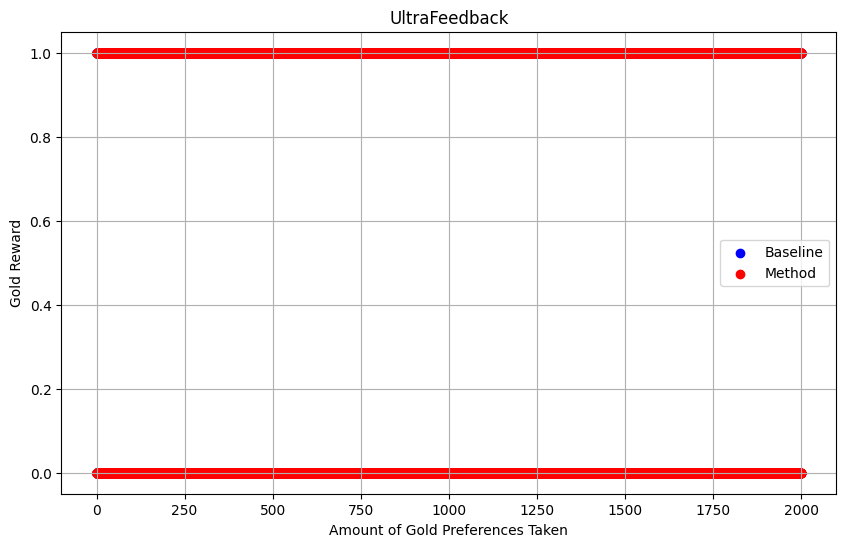

In [104]:
fig = ratio_scatter(baseaccs, methaccs, 2000, mratios[dset], mratios[dset], "efficientplots/"+dset+".pdf", "UltraFeedback")

In [47]:
basengs[-5]

[2.234375,
 2.265625,
 2.296875,
 2.234375,
 2.203125,
 2.1875,
 2.25,
 -0.0224609375,
 2.546875,
 2.53125,
 2.546875,
 2.4375,
 2.1875,
 1.8671875,
 2.53125,
 2.609375,
 2.671875,
 2.4375,
 2.15625,
 2.03125,
 2.375,
 2.40625,
 2.265625,
 2.21875,
 -0.00897216796875,
 1.8828125,
 2.140625,
 2.125,
 2.5625,
 2.515625,
 2.40625,
 2.453125]

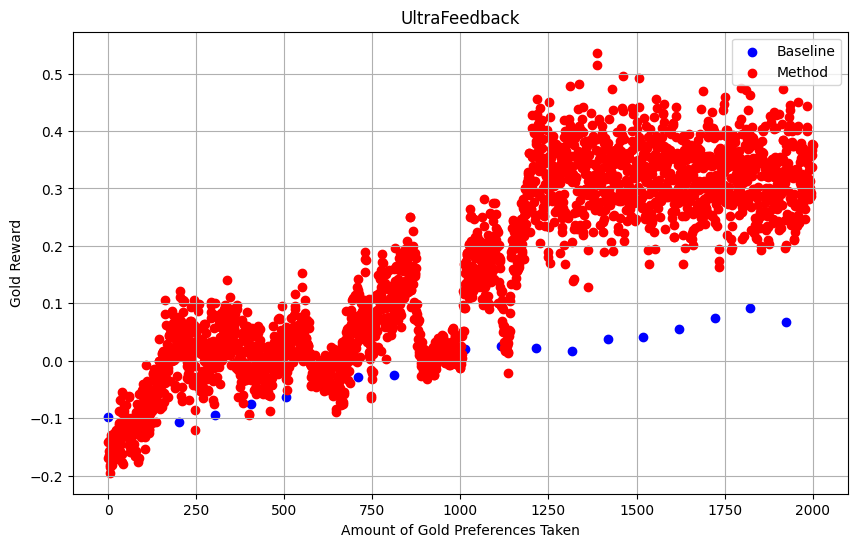

In [19]:
fig = ratio_scatter(basemeans, methmeans, 2000, baseratio, mratios[dset], "efficientplots/"+dset+".pdf", "UltraFeedback")

In [36]:
ngs, accs = makengs(tmp)

0.049515625


In [40]:
meanngs = list([mean(n) for n in ngs])

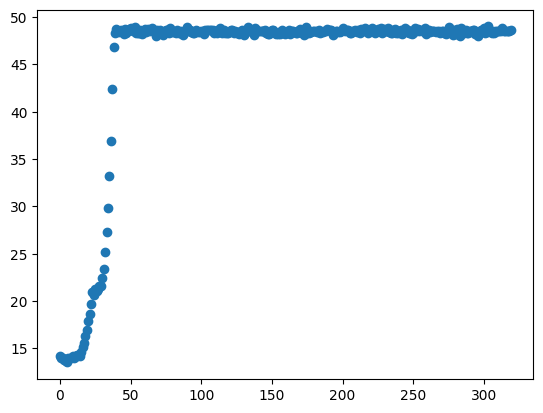

In [42]:
accscatter(meanngs)

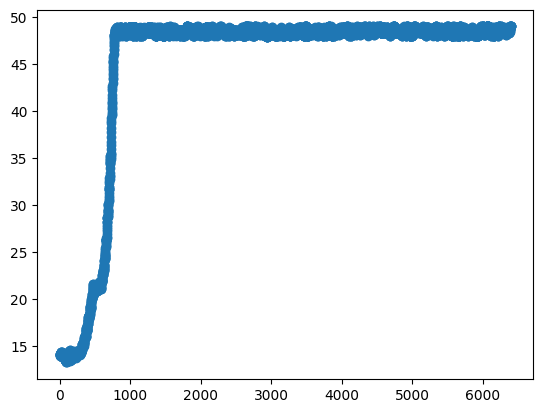

In [15]:
means = [mean(m) for m in ngs]
# means = [mean(m) for m in tmp['rewards']]

interv = 10
mbins = [mean(means[i:i+100]) for i in range(0, len(means), interv)]
plt.scatter(range(len(mbins)), mbins)

In [55]:
print(max(mbins))
print(mean(mbins[-100:]))

49.0
48.5851


In [194]:
tmp.iloc[1000:1010]

,texts,rewards,golds,call
1000,[Question: (((8 * 6) * 2) + 9) = \n\nAnswer: ...,"[-0.23632812500000003, -0.33984375]","[2.619047619047619, 2.611111111111111]","[63, 63]"
1001,[Question: (((2 * 9) * 4) - 2) = \n\nAnswer: ...,"[-0.2353515625, -0.2412109375]","[3.174603174603174, 3.611111111111111]","[63, 63]"
1002,[Question: (((7 * 8) - 4) - 8) = \n\nAnswer: ...,"[-0.208984375, -0.2314453125]","[2.444444444444444, 2.0]","[63, 63]"
1003,[Question: (((4 * 9) - (2 - 7)) - 2) = \n\nAns...,"[0.125, 0.12304687500000001]","[2.70021645021645, 1.7568779904306222]","[63, 63]"
1004,[Question: (((3 * 5) - 1) + 8) = \n\nAnswer: ...,"[-0.2470703125, -0.27734375]","[3.055555555555556, 2.166666666666667]","[63, 63]"
1005,[Question: (((9 * 3) * 5) + (4 * 3)) = \n\nAns...,"[-0.255859375, -0.259765625]","[3.178436147186147, 2.76176948051948]","[63, 63]"
1006,[Question: (((8 * 2) * 2) - 7) = \n\nAnswer: r...,"[-0.039306640625, -0.279296875]","[2.111111111111111, 2.444444444444444]","[63, 63]"
1007,[Question: (((1 * 4) * 1) * 4) = \n\nAnswer: ...,"[-0.1142578125, -0.2734375]","[4.166666666666667, 3.092592592592593]","[63, 63]"
1008,[Question: (((1 * 3) + 6) - 2) = \n\nAnswer: ...,"[-0.373046875, -0.251953125]","[2.777777777777777, 5.0]","[64, 64]"
1009,[Question: (((4 - 2) - 9) + (2 + 9)) = \n\nAns...,"[0.0137939453125, -0.23828125]","[2.285714285714286, 2.957417582417582]","[64, 64]"


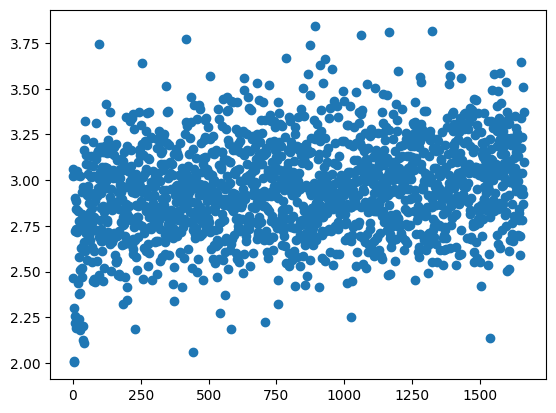

In [50]:
means = [mean(m) for m in tmp['golds']]
plt.scatter(range(len(means)), means)